In [1]:
# --- compare calcite and silicate results
#
# --- from Yoshi (Jan 17, 2024)
# (-CO2_dif_exp-CO2_rsp_exp)-(-CO2_dif_spn-CO2_rsp_spn) - 0.14*(CO2_adv_exp - CO2_adv_spn).
# In the above equation CO2_dif denotes face values in the "diff" column for int_flux_gas-pco2.txt file,  
# CO2_adv in the column of "adv", CO2_rsp in the "g2" column (OM phase considered).  
# "exp" denotes ERW experiments while spn controls/spin-ups.

In [22]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# read in cdr functions
from cdr_fxns import *

# --- 
runtype = "field"   # field or lab
fertlevel = "hi"   # "low", "mid", or "hi"
sitename = "311b"   # "311a" or "311b"

# [SILICATE RUNS]
runname_ctrl_sil = [f"{fertlevel}fert_gbas_{sitename}_0p0_gbas_{runtype}_tau15p0"]
csv_fn_sil = f"meanAnn_gbas_shortRun_{fertlevel}Fert_fixedRate_v2.csv"

# [CALCITE RUNS]
runname_ctrl_cc = [f"{fertlevel}fert_cc_{sitename}_0p0_cc_{runtype}_tau15p0"]
csv_fn_cc = f"meanAnn_liming_shortRun_{fertlevel}Fert_fixedRate_v2.csv"

# ---
# groundwork
outdir = "/home/tykukla/SCEPTER/scepter_output"
csv_loc = "/home/tykukla/aglime-swap-cdr/scepter/batch-inputs"

# ---
# set variable file
var_fn = "flx_gas"  # ["flx_gas" or "flx_co2sp"]
# set cdr variable
cdr_var = "pco2"  # if using *flx_co2sp: [DIC, co2g] ; if using *flx_gas: [pco2]

In [23]:
# --- read in the batch .csv 
dfin_cc = pd.read_csv(os.path.join(csv_loc, csv_fn_cc))
dfin_sil = pd.read_csv(os.path.join(csv_loc, csv_fn_sil))

# [CALCITE]
# add column for the full run id
dfin_cc["newrun_id_full"] = dfin_cc['newrun_id'] + "_" + dfin_cc['dustsp'] + "_" + runtype + "_tau"+dfin_cc["duration"].astype(float).astype(str).str.replace(".", "p")  # (duration has to be turned into float first because otherwise we miss the decimal pt)
# identify the control run
dfin_cc["ctrl_run"] = dfin_cc['newrun_id_full'].isin(runname_ctrl_cc)
if "dustrate" in dfin_cc.columns:
    dfin_cc["dustrate_ton_ha_yr"] = dfin_cc["dustrate"] / 100 
    
# [SILICATE]
# add column for the full run id
dfin_sil["newrun_id_full"] = dfin_sil['newrun_id'] + "_" + dfin_sil['dustsp'] + "_" + runtype + "_tau"+dfin_sil["duration"].astype(float).astype(str).str.replace(".", "p")  # (duration has to be turned into float first because otherwise we miss the decimal pt)
# identify the control run
dfin_sil["ctrl_run"] = dfin_sil['newrun_id_full'].isin(runname_ctrl_sil)
# add a column for the dustrate in ton_ha_yr
if "dustrate" in dfin_sil.columns:
    dfin_sil["dustrate_ton_ha_yr"] = dfin_sil["dustrate"] / 100 


In [24]:
# # --- OPTIONAL: Filter out part of CSV

# # [1] by climatefile name (corresponds with site name)
# site = "site_311a"
# dfin_cc = dfin_cc[dfin_cc['climatefiles'] == 'site_311a']
# dfin_sil = dfin_sil[dfin_sil['climatefiles'] == 'site_311a']

# # [2] ... TK


In [25]:
dfin_cc

,duration,singlerun_seasonality,cec,dustsp,dustsp_2nd,dustrate,dustrate_2nd,dustrad,add_secondary,spinrun,imix,include_psd_full,include_psd_bulk,newrun_id,climatedir,climatefiles,newrun_id_full,ctrl_run,dustrate_ton_ha_yr
0,15,False,21.10329,cc,amnt,0.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_0p0,NaN,site_311a,hifert_cc_311a_0p0_cc_field_tau15p0,False,0.0
1,15,False,21.10329,cc,amnt,20.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_0p2,NaN,site_311a,hifert_cc_311a_0p2_cc_field_tau15p0,False,0.2
2,15,False,21.10329,cc,amnt,40.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_0p4,NaN,site_311a,hifert_cc_311a_0p4_cc_field_tau15p0,False,0.4
3,15,False,21.10329,cc,amnt,60.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_0p6,NaN,site_311a,hifert_cc_311a_0p6_cc_field_tau15p0,False,0.6
4,15,False,21.10329,cc,amnt,80.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_0p8,NaN,site_311a,hifert_cc_311a_0p8_cc_field_tau15p0,False,0.8
5,15,False,21.10329,cc,amnt,100.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_1p0,NaN,site_311a,hifert_cc_311a_1p0_cc_field_tau15p0,False,1.0
6,15,False,21.10329,cc,amnt,200.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_2p0,NaN,site_311a,hifert_cc_311a_2p0_cc_field_tau15p0,False,2.0
7,15,False,21.10329,cc,amnt,300.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_3p0,NaN,site_311a,hifert_cc_311a_3p0_cc_field_tau15p0,False,3.0
8,15,False,21.10329,cc,amnt,700.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_10p0,NaN,site_311a,hifert_cc_311a_10p0_cc_field_tau15p0,False,7.0
9,15,False,21.10329,cc,amnt,1200.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_cc_311a_20p0,NaN,site_311a,hifert_cc_311a_20p0_cc_field_tau15p0,False,12.0


In [26]:
dfin_sil

,duration,singlerun_seasonality,cec,dustsp,dustsp_2nd,dustrate,dustrate_2nd,dustrad,add_secondary,spinrun,imix,include_psd_full,include_psd_bulk,newrun_id,climatedir,climatefiles,newrun_id_full,ctrl_run,dustrate_ton_ha_yr
0,15,False,21.10329,gbas,amnt,0.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_0p0,NaN,site_311a,hifert_gbas_311a_0p0_gbas_field_tau15p0,False,0.0
1,15,False,21.10329,gbas,amnt,20.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_0p2,NaN,site_311a,hifert_gbas_311a_0p2_gbas_field_tau15p0,False,0.2
2,15,False,21.10329,gbas,amnt,40.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_0p4,NaN,site_311a,hifert_gbas_311a_0p4_gbas_field_tau15p0,False,0.4
3,15,False,21.10329,gbas,amnt,60.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_0p6,NaN,site_311a,hifert_gbas_311a_0p6_gbas_field_tau15p0,False,0.6
4,15,False,21.10329,gbas,amnt,80.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_0p8,NaN,site_311a,hifert_gbas_311a_0p8_gbas_field_tau15p0,False,0.8
5,15,False,21.10329,gbas,amnt,100.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_1p0,NaN,site_311a,hifert_gbas_311a_1p0_gbas_field_tau15p0,False,1.0
6,15,False,21.10329,gbas,amnt,200.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_2p0,NaN,site_311a,hifert_gbas_311a_2p0_gbas_field_tau15p0,False,2.0
7,15,False,21.10329,gbas,amnt,300.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_3p0,NaN,site_311a,hifert_gbas_311a_3p0_gbas_field_tau15p0,False,3.0
8,15,False,21.10329,gbas,amnt,700.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_10p0,NaN,site_311a,hifert_gbas_311a_10p0_gbas_field_tau15p0,False,7.0
9,15,False,21.10329,gbas,amnt,1200.0,30.0,150,False,site_311a_pr9_spintuneup4,1,False,False,hifert_gbas_311a_20p0,NaN,site_311a,hifert_gbas_311a_20p0_gbas_field_tau15p0,False,12.0


In [27]:
# --- read in flux data
# [CALCITE]
df_cc = read_flux(dfin_cc, var_fn, outdir, fn_varInclude = [])
df_cc = cdr_dif_adv(df_cc, cdr_var, feedstock = dfin_cc['dustsp'].values[0])
# df_cc

now reading in run 1 of 22...
now reading in run 2 of 22...
now reading in run 3 of 22...
now reading in run 4 of 22...
now reading in run 5 of 22...
now reading in run 6 of 22...
now reading in run 7 of 22...
now reading in run 8 of 22...
now reading in run 9 of 22...
now reading in run 10 of 22...
now reading in run 11 of 22...
now reading in run 12 of 22...
now reading in run 13 of 22...
now reading in run 14 of 22...
now reading in run 15 of 22...
now reading in run 16 of 22...
now reading in run 17 of 22...
now reading in run 18 of 22...
now reading in run 19 of 22...
now reading in run 20 of 22...
now reading in run 21 of 22...
now reading in run 22 of 22...
hifert_cc_311a_0p0_cc_field_tau15p0
hifert_cc_311a_0p2_cc_field_tau15p0
hifert_cc_311a_0p4_cc_field_tau15p0
hifert_cc_311a_0p6_cc_field_tau15p0
hifert_cc_311a_0p8_cc_field_tau15p0
hifert_cc_311a_10p0_cc_field_tau15p0
hifert_cc_311a_1p0_cc_field_tau15p0
hifert_cc_311a_20p0_cc_field_tau15p0
hifert_cc_311a_2p0_cc_field_tau15p0
h

In [28]:
# --- read in flux data and compute cdr 
# [SILICATE]
df_sil = read_flux(dfin_sil, var_fn, outdir, fn_varInclude = [])
df_sil = cdr_dif_adv(df_sil, cdr_var, feedstock = dfin_sil['dustsp'].values[0])
# df_sil

now reading in run 1 of 22...
now reading in run 2 of 22...
now reading in run 3 of 22...
now reading in run 4 of 22...
now reading in run 5 of 22...
now reading in run 6 of 22...
now reading in run 7 of 22...
now reading in run 8 of 22...
now reading in run 9 of 22...
now reading in run 10 of 22...
now reading in run 11 of 22...
now reading in run 12 of 22...
now reading in run 13 of 22...
now reading in run 14 of 22...
now reading in run 15 of 22...
now reading in run 16 of 22...
now reading in run 17 of 22...
now reading in run 18 of 22...
now reading in run 19 of 22...
now reading in run 20 of 22...
now reading in run 21 of 22...
now reading in run 22 of 22...
hifert_gbas_311a_0p0_gbas_field_tau15p0
hifert_gbas_311a_0p2_gbas_field_tau15p0
hifert_gbas_311a_0p4_gbas_field_tau15p0
hifert_gbas_311a_0p6_gbas_field_tau15p0
hifert_gbas_311a_0p8_gbas_field_tau15p0
hifert_gbas_311a_10p0_gbas_field_tau15p0
hifert_gbas_311a_1p0_gbas_field_tau15p0
hifert_gbas_311a_20p0_gbas_field_tau15p0
hifer

In [29]:
df_cc

,time,tflx,adv,dif,rain,ct,inrt,cabd,gb,cc,...,site,ctrl,dustrate_ton_ha_yr,dustrad,dustsp,cdr_dif_component,cdr_resp_component,cdr_adv_component,cdr_dif,cdr_adv
2,0.001251,0.037662,0.625233,24.716073,0.0,0.0,0.0,0.0,0.0,-0.014529,...,site_311a,False,0.0,150,cc,NaN,NaN,NaN,NaN,NaN
66,0.001251,0.018180,0.625262,24.735526,0.0,0.0,0.0,0.0,0.0,-0.014530,...,site_311a,False,0.0,150,cc,NaN,NaN,NaN,NaN,NaN
3,0.003751,-0.061234,0.625207,24.814999,0.0,0.0,0.0,0.0,0.0,-0.014533,...,site_311a,False,0.0,150,cc,NaN,NaN,NaN,NaN,NaN
67,0.003751,-0.110722,0.625194,24.864501,0.0,0.0,0.0,0.0,0.0,-0.014535,...,site_311a,False,0.0,150,cc,NaN,NaN,NaN,NaN,NaN
4,0.006251,-0.082260,0.625103,24.836130,0.0,0.0,0.0,0.0,0.0,-0.014536,...,site_311a,False,0.0,150,cc,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,13.750001,0.123478,1.232997,22.187075,0.0,0.0,0.0,0.0,0.0,-0.757813,...,site_311b,False,3.0,150,cc,0.455705,-0.000695,1.069021,0.455010,0.534163
2366,14.375001,0.011803,1.410052,23.569354,0.0,0.0,0.0,0.0,0.0,-0.944808,...,site_311b,False,3.0,150,cc,0.190005,0.000749,1.094889,0.190005,0.547444
2430,14.375001,-0.038240,1.247521,22.442039,0.0,0.0,0.0,0.0,0.0,-0.962187,...,site_311b,False,3.0,150,cc,0.111418,-0.000724,1.091135,0.110694,0.545205
2367,15.000000,0.015483,1.401969,23.508182,0.0,0.0,0.0,0.0,0.0,-0.937880,...,site_311b,False,3.0,150,cc,0.198988,0.000688,1.093583,0.198988,0.546791


In [34]:
# --- get netCDR - loss rate data array
cc_app_fixed = 1.0   # [ton ha-1 yr-1] application rate used for counterfactual scenario
time_horizon = 15
# [yr] time horizon for comparing integrated CDR 
cdvar = "cdr_dif"
thissite = f"site_{sitename}"

# compute
da = cdr_compare_lossrange(df_cc, df_sil, cc_app_fixed, time_horizon, cdvar, thissite, var_fn, cdr_var)

# get cdr versus application rate
dfcc_ar, dfsil_ar = cdr_per_apprate(df_cc, df_sil, time_horizon, cdvar, thissite, var_fn, cdr_var)

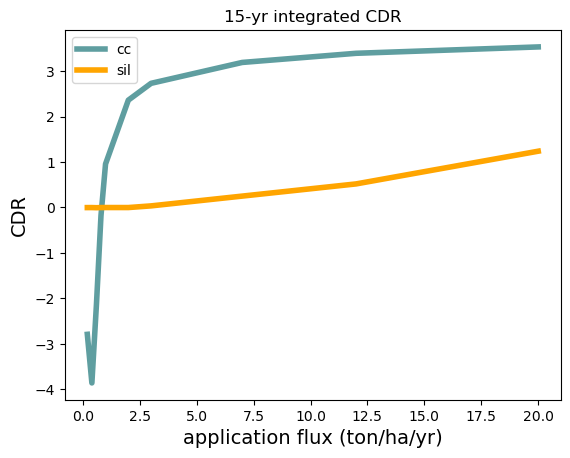

In [35]:
# --- PLOT CC AND SIL CDR VERSUS APPLICATION RATE
plt.plot(dfcc_ar['apprate'], dfcc_ar['cdr'], c='cadetblue', linewidth=4, label='cc')
plt.plot(dfsil_ar['apprate'], dfsil_ar['cdr'], c='orange', linewidth=4, label='sil')
plt.title(str(time_horizon) + '-yr integrated CDR')
plt.xlabel('application flux (ton/ha/yr)', fontsize=14)
plt.ylabel('CDR', fontsize=14)
plt.legend()

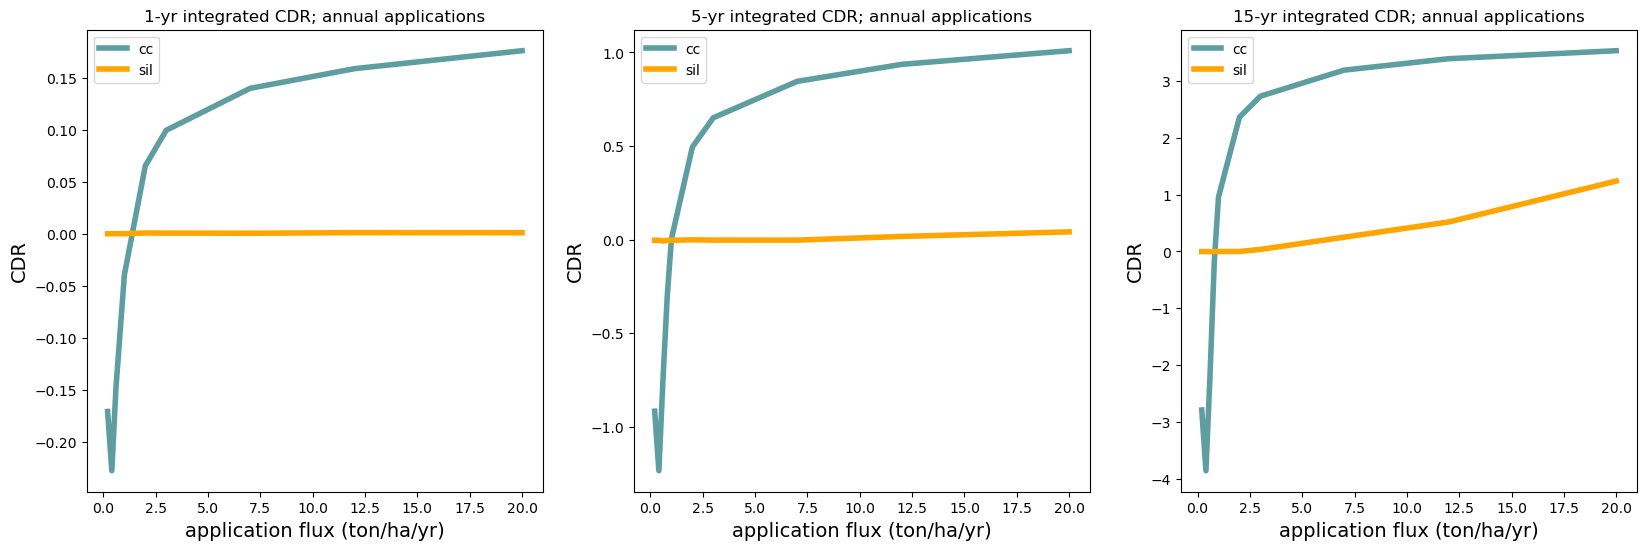

In [36]:
# --- check a couple timeslices
time_horizons = (1,5,15)     # [yr] time horizon for comparing integrated 

# set up plot grid
spec = GridSpec(ncols=3, nrows=1, hspace=0.15)
plt.figure(figsize=(20, 6))
plotdx = 0

for time_horizonx in time_horizons:
    dfcc_ar, dfsil_ar = cdr_per_apprate(df_cc, df_sil, time_horizonx, cdvar, thissite, var_fn, cdr_var)
    # make the plot
    ax = plt.subplot(spec[plotdx])
    plt.plot(dfcc_ar['apprate'], dfcc_ar['cdr'], c='cadetblue', linewidth=4, label='cc')
    plt.plot(dfsil_ar['apprate'], dfsil_ar['cdr'], c='orange', linewidth=4, label='sil')
    plt.title(str(time_horizonx) + '-yr integrated CDR; annual applications')
    plt.xlabel('application flux (ton/ha/yr)', fontsize=14)
    plt.ylabel('CDR', fontsize=14)
    plt.legend()
    
    # move to next panel
    plotdx += 1

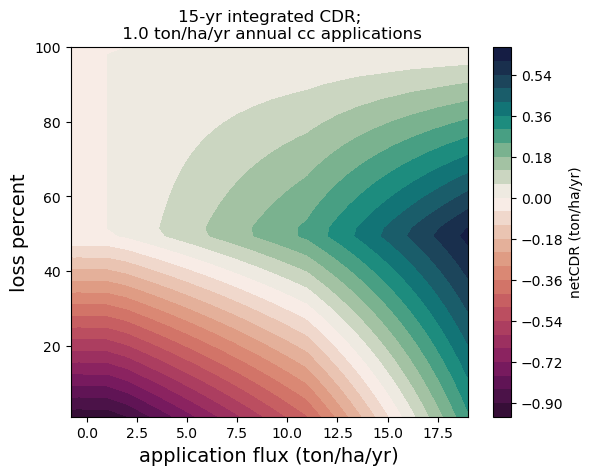

In [37]:
# --- 2d loss array
from matplotlib.colors import TwoSlopeNorm

ds = da.to_dataset(name='netcdr')
y = ds['loss_percent'].values
x = ds['D_appRate'].values

# Define the midpoint normalization
norm = TwoSlopeNorm(vmin=ds['netcdr'].min(), vmax=ds['netcdr'].max(), vcenter=0)

contour = plt.contourf(x,y,ds['netcdr'], levels=30, cmap = cmo.curl_r, norm=norm)
cbar = plt.colorbar(contour)
cbar.set_label('netCDR (ton/ha/yr)')
plt.title(str(time_horizon) + '-yr integrated CDR;\n ' + str(cc_app_fixed) + " ton/ha/yr annual cc applications")
plt.xlabel("application flux (ton/ha/yr)", fontsize=14)
plt.ylabel("loss percent", fontsize=14)
plt.show();

In [42]:
y = ds['loss_percent'].values
x = ds['D_appRate'].values

array([-0.8, -0.6, -0.4, -0.2,  0. ,  1. ,  2. ,  9. , 19. , 29. ])

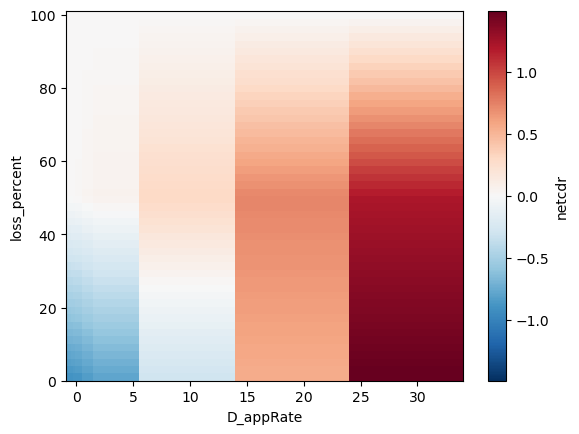

In [55]:
ds['netcdr'].plot()

In [11]:
# -----------------------

In [ ]:
# -----------------------

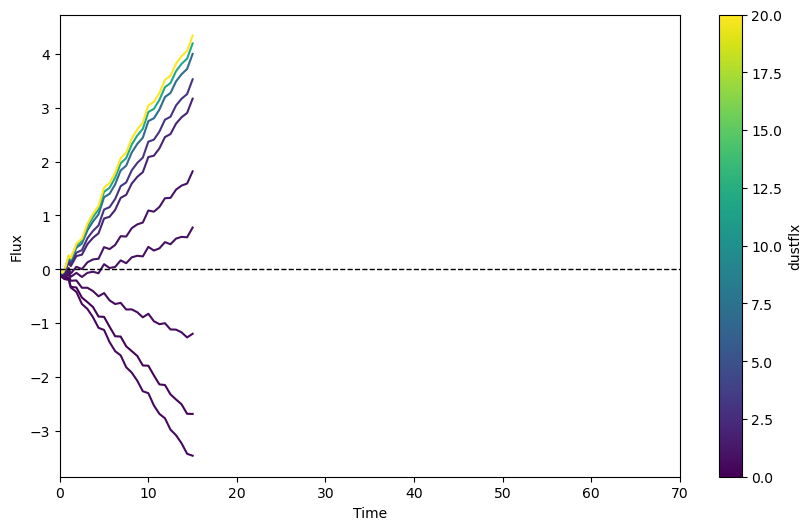

In [81]:
# --- cdr timeseries plot check
### set site
tsite = "site_311a" 
df = df_cc

dfint = df.loc[(df["ctrl"] == False) & (df["set"] == ("int_"+var_fn)) & (df["var"] == cdr_var) & (df["site"] == tsite)]
dfx = df.loc[(df["ctrl"] == False) & (df["set"] == var_fn) & (df["var"] == cdr_var) & (df["site"] == tsite)]

# which to plot
int_on = True
thisdf = dfint
cdvar = "cdr_dif"

# Group by 'iteration'
grouped = thisdf.groupby('dustrate_ton_ha_yr')

# set cmap
norm = Normalize(vmin=df['dustrate_ton_ha_yr'].min(), vmax=df['dustrate_ton_ha_yr'].max())
cmap = plt.get_cmap('viridis')

# Plotting
plt.figure(figsize=(10, 6))
for name, group in grouped:
    if int_on:
        plt.plot(group['time'], group[cdvar]*group['time'], color=cmap(norm(name)))
    else:
        plt.plot(group['time'], group[cdvar], color=cmap(norm(name)))

plt.xlim(0,70)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Flux')
if cdvar in ["cdr_dif_component", "cdr_dif"]:
    if int_on:
        print("")
        #plt.ylim(-10,800)
    else:
        print("")
        # plt.ylim(-10, 30)
# plt.legend()
# Create colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('dustflx')

# Show plot
plt.show()
